<a href="https://colab.research.google.com/github/dharma610/Project/blob/master/SIR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364065 sha256=35453895979cef77f96953c5054314d59762ef28908da55e58b98ca1244949e1
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [2]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [3]:
def plotsir(t, S, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.set_xlabel('Time (days)')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

In [4]:
""" gamma is a list of 1000 random number in (0,1) """

import random
gamma = []
for i in range(1000):
    gamma.append(random.uniform(0, 1))
    


In [5]:
""" beta is twice of each of 1000 gamma values """
beta = []
for i in range(1000):
  beta.append(2*gamma[i])  

In [6]:
""" P, Q, M are the list of S, I, R respectievely calculated for 100 days for each of  1000 sets of parameter (beta,gamma)."""
    
P = []
Q = []
M  = []
for i in range(1000): #Plotted for 2 sets
  N = 1000
  S0, I0, R0 = 999, 1, 0  # initial conditions: one infected, rest susceptible
  t = np.linspace(0, 99, 100) # Grid of time points (in days)
  y0 = S0, I0, R0 # Initial conditions vector
  # Integrate the SIR equations over the time grid, t.
  ret = odeint(deriv, y0, t, args=(N, beta[i], gamma[i]))
  S, I, R = ret.T
  P.append(S)
  Q.append(I)
  M.append(R)

  

In [7]:
""" list to dataftrame """

S_value = pd.DataFrame(P)
I_value = pd.DataFrame(Q)
R_value = pd.DataFrame(M)

In [8]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
s_list = []
i_list = []
r_list = []
s_list1 = []
i_list1= []
r_list1= []
for i in range(1000):
  s_list.append(array(S_value.iloc[i][0:70]))
  i_list.append(array(I_value.iloc[i][0:70]))
  r_list.append(array(R_value.iloc[i][0:70]))


for i in range(1000):
  s_list1.append(array(S_value.iloc[i][70:]))
  i_list1.append(array(I_value.iloc[i][70:]))
  r_list1.append(array(R_value.iloc[i][70:]))  

In [9]:
# reshape series
for i in range(1000):
  s_list[i] =s_list[i].reshape(70,1)
  i_list[i] =i_list[i].reshape(70,1)
  r_list[i] =r_list[i].reshape(70,1)

for i in range(1000):
  s_list1[i] =s_list1[i].reshape(30,1)
  i_list1[i] =i_list1[i].reshape(30,1)
  r_list1[i] =r_list1[i].reshape(30,1)  

In [10]:
p = []
q = []
r = []
p1 = []
q1 = []
r1 = []
for i in range(1000):
  p.append(s_list[i])
  q.append(i_list[i])
  r.append(r_list[i])
for i in range(1000):
  p1.append(s_list1[i])
  q1.append(i_list1[i])
  r1.append(r_list1[i])  



In [11]:
s = tuple(p)
t = tuple(q)
u = tuple(r)

s1 = tuple(p1)
t1 = tuple(q1)
u1 = tuple(r1)

In [12]:
# horizontally stack columns
dataset = hstack(s)
# define generator
n_input = 2
n_features = dataset.shape[1]
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(generator))

Samples: 68


In [13]:
# horizontally stack columns
dataset1 = hstack(s1)
# define generator
n_input = 2
n_features = dataset.shape[1]
generator1 = TimeseriesGenerator(dataset1, dataset1, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(generator1))

Samples: 28


In [14]:
train = []
# print each sample
for i in range(len(generator)):
  x, y = generator[i]
  train.append(x)
	


In [15]:
test = []
# print each sample
for i in range(len(generator1)):
  x, y = generator1[i]
  test.append(x)
	


In [16]:
train[67]

array([[[202.84590276, 203.44312057, 202.84589959, ..., 202.84589959,
         202.84590005, 216.51119493],
        [202.84590186, 203.35869571, 202.84589959, ..., 202.84589959,
         202.84589991, 215.12796429]]])

In [17]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1000))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator1, steps_per_epoch=1, epochs=500, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


In [31]:
# make a one step prediction out of sample
x_input = test[0].reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 211.09035  208.28708  216.562    213.14906  284.37    1011.2233
   204.83594  209.42381  212.44777  315.4536   209.83704  215.68742
   215.75214  210.53297  206.69498  209.04555  207.88821  228.34406
   212.12282  218.31926  426.83072  211.79056  210.02402  212.35965
   214.1386   210.91037 1004.115    207.70665  210.08989  213.63698
   215.01541  209.83446  213.28876  208.34451  208.0775   210.29839
   210.31557 1023.2173   208.24866  210.31708  218.12967  209.36143
   215.37842  210.58032  208.3119   210.07167  211.02061  346.07297
   205.39285  210.10535 1016.41034  212.32915  213.78448  211.29149
   214.98657 1026.7511   206.7494   885.4611   209.3993   208.22513
   211.6344   208.54176  213.43852  211.38316  208.49847  204.9645
   207.44931  207.6951   212.32259  215.6138   657.15607  905.4641
   206.63576  212.45592  214.94417  212.42114  211.64641  208.05745
   209.2183   208.82697  209.90152  212.14426  213.90398  212.43677
   209.76698  214.95963  211.22171  208.2848   206.

In [32]:
df1 = pd.DataFrame(yhat)

In [33]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,211.090347,208.287079,216.561996,213.149063,284.369995,1011.223328,204.835938,209.423813,212.447769,315.453613,209.837036,215.687424,215.752136,210.532974,206.694977,209.045547,207.888214,228.344055,212.122818,218.31926,426.830719,211.790558,210.024017,212.35965,214.138596,210.91037,1004.11499,207.70665,210.08989,213.636978,215.015411,209.834457,213.288757,208.344513,208.077499,210.298386,210.315567,1023.217285,208.248657,210.317078,...,209.696579,211.014481,220.427109,205.285507,212.064194,236.126541,209.641815,210.208847,210.679718,206.807877,208.018097,213.871109,216.216919,208.009689,205.115051,211.245438,214.769089,212.097977,212.301865,207.659744,210.908539,206.219727,213.261597,217.780701,209.615341,205.965195,210.600281,205.988419,216.076767,209.582962,251.752121,891.762756,213.218033,208.482742,209.988831,213.10675,216.938782,215.062927,207.974686,213.346588


In [46]:
df2 = pd.DataFrame(test[1].tolist()[0])
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,202.8459,203.170535,202.8459,202.906295,351.544391,989.221286,202.845904,202.8459,202.8459,401.093870,202.8459,202.845907,202.848568,204.995242,202.8459,202.845906,202.8459,233.626924,202.8459,202.8459,543.060943,202.848527,202.854262,202.845945,202.8459,202.847199,982.678124,202.870584,202.8459,202.8459,212.377977,202.8459,202.8459,202.8459,202.8459,202.8459,202.8459,993.563495,202.8459,202.934532,...,202.861018,202.8459,227.014553,202.8459,202.845909,275.258325,202.937807,202.850074,202.845918,202.8459,203.124624,202.8459,202.8459,202.8459,202.846082,202.845902,202.8459,219.429315,202.8459,202.8459,202.97383,202.8459,202.845978,205.517632,202.8459,202.845910,202.8459,202.846200,202.8459,202.8459,294.791066,926.118518,202.913709,202.888269,202.8459,202.8459,202.8459,202.8459,202.8459,211.767473
1,202.8459,203.124652,202.8459,202.896547,341.870614,988.926330,202.845903,202.8459,202.8459,389.327109,202.8459,202.845905,202.848041,204.740914,202.8459,202.845904,202.8459,230.975643,202.8459,202.8459,528.114856,202.848007,202.852720,202.845934,202.8459,202.846932,982.107514,202.866340,202.8459,202.8459,211.423376,202.8459,202.8459,202.8459,202.8459,202.8459,202.8459,993.425374,202.8459,202.920628,...,202.858333,202.8459,224.863510,202.8459,202.845907,269.774786,202.923429,202.849271,202.845913,202.8459,203.084717,202.8459,202.8459,202.8459,202.846041,202.845901,202.8459,217.879002,202.8459,202.8459,202.95432,202.8459,202.845960,205.208610,202.8459,202.845907,202.8459,202.846133,202.8459,202.8459,288.121295,922.541806,202.902857,202.881253,202.8459,202.8459,202.8459,202.8459,202.8459,210.866860


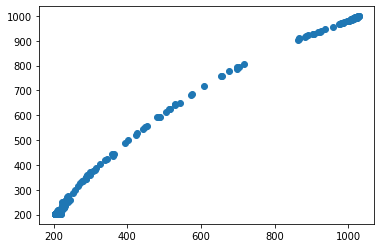

In [45]:
plt.scatter(df1.iloc[0],df2.iloc[1])